### Alinhamento

In [59]:
import glob
import numpy as np
import cv2
from PIL import Image
import PIL
import imutils
import skimage
from skimage import filters
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7)

pytesseract.pytesseract.tesseract_cmd='C:\Program Files\Tesseract-OCR\tesseract.exe'

In [45]:
#funcao para cortar parte preta das imagens capturadas pela camera chinesa, pois atrapalham a segmentação
def cropImg(img):
    crop = img[800:1800, 1000:2200]
    return crop

def cropAlign(img):
    crop = img[1020:1630, 1200:2100]
    return crop

def sift_align(img1, img2):
    
    # Converte imagens para cinza
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detecta recursos SIFT
    sift = cv2.SIFT_create(5000)
    keypoints1, descriptors1 = sift.detectAndCompute(img1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2Gray, None)

    # Match features (Recursos de combinações)
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remova combinações não tão boas
    numGoodMatches = int(len(matches) * 2)
    matches = matches[:numGoodMatches]

    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Encontra homografia
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Usa homografia
    height, width, channels = img2.shape
    
    img1Reg = cv2.warpPerspective(img1, h, (width, height))

    return img1Reg, h

def orb_align(img1, img2):
    
    # Converte imagens para cinza
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detecta recursos SIFT
    orb = cv2.ORB_create(5000)
    keypoints1, descriptors1 = orb.detectAndCompute(img1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2Gray, None)

    # Match features (Recursos de combinações)
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remova combinações não tão boas
    numGoodMatches = int(len(matches) * 2)
    matches = matches[:numGoodMatches]

    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Encontra homografia
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Usa homografia
    height, width, channels = img2.shape
    
    img1Reg = cv2.warpPerspective(img1, h, (width, height))

    return img1Reg, h

### Segmentação

In [5]:
def crop_name_seg(img):
    imgcrop = img[100:100+40, 90:90+490] 
    return imgcrop

In [6]:
def gaussianBlurring(img):
    blur1 = cv2.GaussianBlur(img, (5, 5), 0)
    return blur1

In [7]:
def inverte(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #ret,thresh1 = cv2.threshold(gray,137,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(gray,137,255,cv2.THRESH_BINARY_INV)
    return thresh2

In [8]:
def settozero(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
    return thresh

In [9]:
def conv_edges(img):
    convolution_matrix = np.array([[0,1,0],
                                  [1,-4,1],
                                  [0,1,0]]) #filtro/matriz para detecção de bordas
    edg = cv2.filter2D(img, -1, convolution_matrix)
    return edg

In [10]:
def sharpenFunction(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) #matriz de convolução que aplica nitidez
    return cv2.filter2D(image, -1, kernel)

In [11]:
def filterFunction(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (T,Thresh1) = cv2.threshold(gray, 187, 255, cv2.THRESH_TRUNC)
    Thresh2 = cv2.adaptiveThreshold(Thresh1, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 231,50)
    return Thresh2

In [12]:
def bilateral(img):
    bil = cv2.bilateralFilter(img, 11, 77, 77) #3, 21, 21 #5, 35, 35 #7, 49, 49 #9, 63, 63 #11, 77, 77
    return bil

In [13]:
def thresholdLocal(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    T = skimage.filters.threshold_local(gray, 11, offset = 10, method = "gaussian")
    imag = (gray > T).astype("uint8") * 255
    return imag

In [14]:
def cleanImage(image, stage = 0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # aplicando as operações topHat/blackHat
    topHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel) #revela as áreas claras com fundo escuro
    blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel) #revela as áreas escuras com um fundo claro
    # fazendo adição e subtração entre as operações morfológicas
    add = cv2.add(gray, topHat)
    subtract = cv2.subtract(add, blackHat)
    if (stage == 1):
        return subtract
    T = filters.threshold_local(subtract, 29, offset=7, method="gaussian", mode="mirror")
    thresh = (subtract > T).astype("uint8") * 255
    if (stage == 2):
        return thresh
    # inverte a imagem 
    thresh = cv2.bitwise_not(thresh)
    return thresh

In [15]:
def find_contours(image):
    contours,hierarchy = cv2.findContours(dilate,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    return contours

### OCR

In [16]:
import pytesseract
from pytesseract import Output
import re

def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

def drawboxes(img, d):
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #if int(d['conf'][i]) > 40:
        if int(d['left'][i]) > 90 and int(d['top'][i]) > 90:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img

#limpa caracteres não ASCII
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

def extraiNome(img):
    crop = img[110:180, 120:850]
    text = pytesseract.image_to_string(crop, lang='por')
    name = cleanup_text(text)
    name = re.findall('[A-Z]+', name)
    nomecomp = ""
    
    for n in name:
        nomecomp += f" {n}"
    
    res = re.sub("NOME", "", nomecomp)
    
    print(res)
    
    return crop

def get_cpf_roi(img):
    
    imgcrop = img[240:300, 415:680]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    text = cleanup_text(text)
    cpf = ""
    
    cpf = re.findall('[0-9]+', text)
    newcpf = ""
    
    for n in cpf:
        newcpf += f" {n}"
     
    print("CPF:", newcpf)
    #print(text)
    
    return imgcrop

def get_datanasc_roi(img):
    
    imgcrop = img[240:300, 670:850]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    data = re.findall("\d{2}\/\d{2}\/\d{4}", text)
    print(data)
    
    return imgcrop

def get_nreg_roi(img):
    
    imgcrop = img[510: , 110:420]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    num = re.findall('[0-9]+', text)
    numreg = ""
    
    for n in num:
        numreg += f" {n}"
        
    print(numreg)
    
    return imgcrop

def get_dataval_roi(img):
    
    imgcrop = img[290:290+50, 210:210+125]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    data = re.findall('\d{2}/\d{2}/\d{4}', text)
    print(data)
    
    return imgcrop

## TESTES

### Alinhamento

In [53]:
images = glob.glob("../teste1/imgs/*.jpg")
ref = cv2.imread("../teste1/referencias/ref.jpg")
i = 0

for c in images:
    
    img = cv2.imread(c)
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    crop = cropAlign(img)
    cv2.imwrite('../teste1/alinhadas/alinhada%02i.jpg' %i , crop)
    i += 1
    #plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    #s_align,h = sift_align(crop, ref)
    #o_align, h = orb_align(img, ref)
    #plt.imshow(cv2.cvtColor(o_align, cv2.COLOR_BGR2RGB))
    #plt.show()
    
    

### Segmentação + ocr

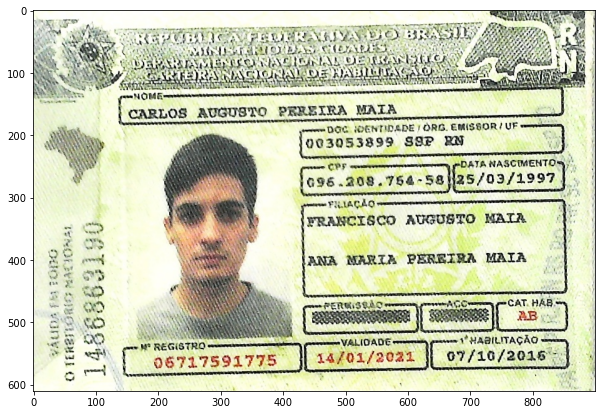

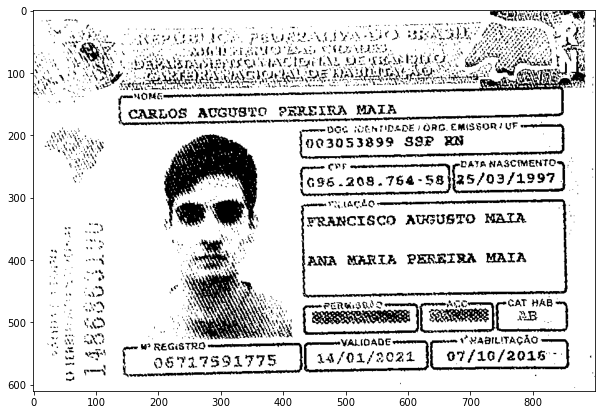

TesseractNotFoundError: C:\Program Files\Tesseract-OCR	esseract.exe is not installed or it's not in your PATH. See README file for more information.

In [60]:
images = glob.glob("../teste1/alinhadas/*.jpg")

for p in images:
    
    img = cv2.imread(p)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    ############ SEGMENTAÇÃO 1 #################
    tozero = settozero(img)
    ret,thresh = cv2.threshold(tozero,125,255,cv2.THRESH_BINARY)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.show()
    
    keys = data_keys(thresh)
    boxes = drawboxes(thresh, keys)
    plt.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB))
    plt.show()
   
    ############ SEGMENTAÇÃO 2 ################
    nitida = sharpenFunction(img)
    filt = filterFunction(nitida)
    blur = cv2.medianBlur(filt, 3)
    plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    ############ SEGMENTAÇÃO 3 ################
    bil = bilateral(img)
    thlocal = thresholdLocal(bil)
    plt.imshow(cv2.cvtColor(thlocal, cv2.COLOR_BGR2RGB))
    plt.show()

### Resultados

Os resultados usando a função image_to_data foram basicamentes os mesmos em todas as segmentações;

> Visualmente os melhores filtros são: 
    Sharpen + Adaptative (FilterFunction) + medianBlur e Bilateral + ThresholdLocal
    
 
> Na leitura dos nomes os melhores filtros foram o 2 e o 3


> Na leitura dos cpf também dois e 3


> Na leitura de data o melhor filtro foi o 1


> Número de registro: filtro 1
